In [73]:
import numpy as np
from importlib import reload
from scipy import signal

import plotting_tools as pt
import utils
import dsi
utils = reload(utils)
pt = reload(pt)
dsi = reload(dsi)

import pickle
import sys
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../RKLM_Python/')

from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
from matplotlib import rc

# activate latex text rendering
rc('text', usetex=True)

In [74]:
Nx, Ny = 301, 10
# Nx, Ny = 1201, 80
ib = False

N = 1

def load(Nx,Ny,et):
    base_fn = 'output_mark_wave'
    pydir = '../%s/' %base_fn

    tc = utils.test_case(base_fn, pydir, Nx, Ny, et)
    tags = tc.get_tag_dict()
    
    return tc, tags

i2 = (slice(2,-2),slice(2,-2))

debug_ic debug_ic


/home/ray/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


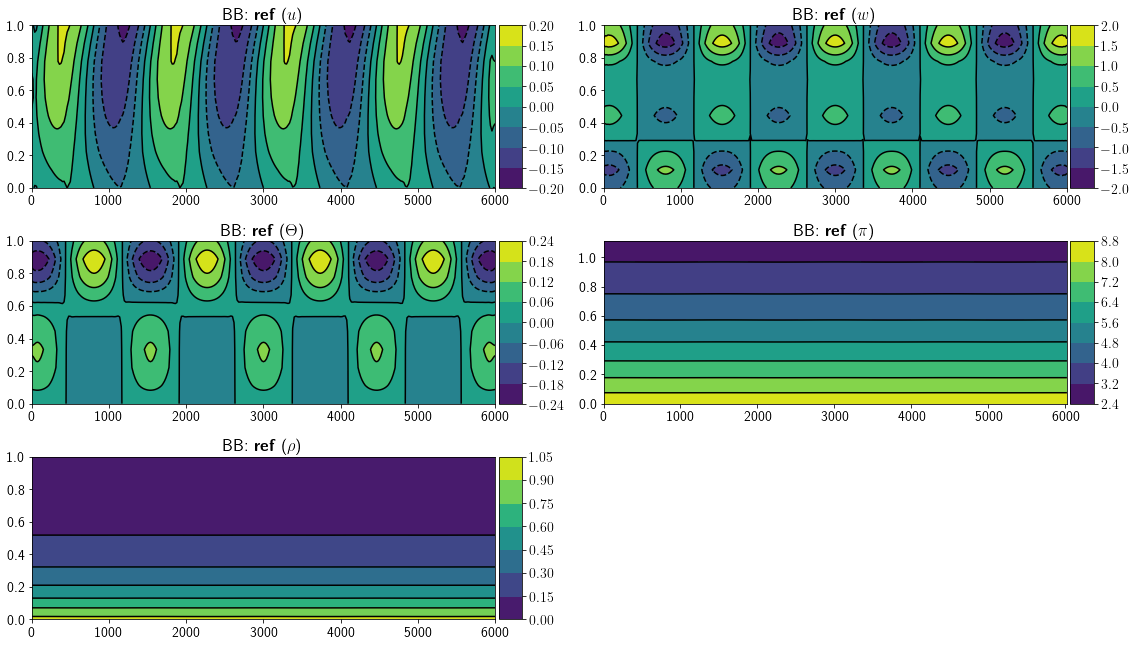

In [83]:
l_typ = 'WINDOW_STEP'
diff = False

attr_labels = pt.labels()

def get_ens(tc, times, sfx , diff, attribute, tag):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=diff, tag=tag, inner=False)[1]

    label = sfx + '_' + attribute
    return label, ens.T

def get_arr(typ, times, tp='half'):
    et = 8000.0
    sfx1 = '%s' %typ
    if ib: sfx1 = '%s_ib-0' %sfx1
    print(sfx1, typ)

    tc, tags = load(Nx,Ny,et)
    if tp=='afs':
        tag = 'after_full_step'
    else:
        tag = tp

    # load pickled instances of data used in simulation
    fn_pickle = tc.get_filename(N,sfx1,format='dat')
    path_pickle = tc.get_path(fn_pickle)

    file = open(path_pickle,'rb')
    ud = pickle.load(file)
    mpv = pickle.load(file)
    dap = pickle.load(file)
    elem = pickle.load(file)
    file.close()

    S0 = (ud.stratification(elem.y)).reshape(-1,1)
    
    attributes = ['rhou', 'rhov', 'rhoY', 'p2_nodes']
    _, rho = get_ens(tc, times, sfx1, diff, 'rho', tag)
    la = r'BB: '
    if 'best' in typ:
        la += r'\textbf{CS}'
    elif 'imbal' in typ:
        la += r'\textbf{NS}'
    else:
        la += r'\textbf{ref}'
#     la = la + '_' + typ
    ret = []
    
    for attribute in attributes:
        _, aa = get_ens(tc, times, sfx1, diff, attribute, tag)
        if attribute == 'rhoY':
            la_curr = la + r' ($\Theta$)'
        elif attribute == 'rhov':
            la_curr = la + r' ($w$)'
        elif attribute == 'rhou':
            la_curr = la + r' ($u$)'
        else:
            la_curr = la + r' ($\pi$)'
        
        if attribute == 'rhoY':
            aa = aa / rho
            aa -= S0
            aa = aa[i2] * ud.T_ref
        elif attribute == 'rhou':
            aa = aa / rho
            aa = aa[i2] * ud.u_ref
        elif attribute == 'rhov':
            aa = aa / rho
            aa = aa[i2] * ud.u_ref
        elif attribute == 'p2_nodes':
            aa = aa[i2]
            
        ret.append([aa,la_curr])
    
    rho = rho[i2] * ud.rho_ref
    ret.append([rho,la + r' ($\rho$)'])
    return np.array(ret)

typ1 = 'debug_ic'
typ2 = 'debug_ic'
times0 = [200]
times1 = [30]

aa1 = get_arr(typ1,times0, tp='afs')

plot2 = False
if plot2:
    aa2 = get_arr(typ2,times1, tp='afs')

    diffs = []
    for i in range(len(aa1)):
        diffs.append([aa1[i][0]-aa2[i][0], 'diff'])

    pl_lst = np.array(list(zip(aa1,aa2,diffs))).reshape(15,2)
    # pl_lst = np.array(diffs)

    print(pl_lst.shape)

    fac = 1.0
    # pl = pt.plotter(pl_lst,ncols=2,figsize=(16*fac,9*fac),sharey=False)
    pl = pt.plotter(pl_lst,ncols=3,figsize=(24*fac,15*fac),sharey=False)
else:
    pl_lst = aa1
    pl = pt.plotter(pl_lst,ncols=2,figsize=(16*fac,10*fac),sharey=False)
    
x_axs = np.array([0,1000,2000,3000,4000,5000,6000])
# y_axs = [-0.5,-0.25,0.0,0.25,0.5]
y_axs = np.array([0.0,2.0,4.0,6.0,8.0,10.0]) / 10.0
x_loc = np.linspace(0,Nx-1,7)
y_loc = np.linspace(0,Ny-1,6)
# x_label = r'x [$\times 10$ km]'
# y_label = r'y [$\times 10$ km]'

pl.set_axes(y_locs=y_loc,y_axs=y_axs, x_locs=x_loc,x_axs=x_axs)
# pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)
_ = pl.plot(method='contour', lvls=None)

# lbl = 'swe' if swe else 'euler'
# pl.save_fig('initial_vortex_%s' %lbl)